In [4]:
# Import all packages

import numpy as np
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [2]:
# Helper Functions


# returns the points in numpy array
def subsample_points_poisson(inputMesh, radius=4.5):
    '''
        Return sub-sampled points as numpy array.
        The radius might need to be tuned as per the requirements.
    '''
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(radius)
    f.Update()

    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def read_landmarks(filename):
    '''
        Reads the landmarks fscv file and converts the points to correct coordinate system.
        Returns array of size N x 3
    '''
    import pandas as pd
    df = pd.read_csv(filename, comment='#', header=None)

    points_x = np.expand_dims(-1 * np.array(df[1].tolist()), -1)
    points_y = np.expand_dims(-1 * np.array(df[2].tolist()), -1)
    points_z = np.expand_dims(np.array(df[3].tolist()), -1)

    points = np.concatenate([points_x, points_y, points_z], axis=1)

    return points


In [198]:
# File paths

# moving mesh will remain constant which is the template mesh
FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174715-Cranium_1.ply'
MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM176211-Cranium.ply'
FIXED_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM174715_LM1.fcsv'
MOVING_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM176211_LM1.fcsv'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [200]:
# Read the landmarks and create mesh from them

fixed_landmark = read_landmarks(FIXED_LANDMARK_FILE)
moving_landmark = read_landmarks(MOVING_LANDMARK_FILE)

fixed_landmark_mesh = itk.Mesh[itk.D, 3].New()
moving_landmark_mesh = itk.Mesh[itk.D, 3].New()

fixed_landmark_mesh.SetPoints(itk.vector_container_from_array(fixed_landmark.flatten().astype('float32')))
moving_landmark_mesh.SetPoints(itk.vector_container_from_array(moving_landmark.flatten().astype('float32')))

itk_landmarks = [fixed_landmark_mesh, moving_landmark_mesh]

In [201]:
# Write the meshes in vtk format so that they can be read in ITK

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
    
    vtk_mesh = reader.GetOutput()
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [202]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []

itk_images = []
for i, mesh in enumerate(itk_meshes):
    # Make all the points to positive coordinates
    mesh_points = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(mesh_points, 0)
    mesh_points = mesh_points - m
    mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    
    # Apply same subtraction to landmark points
    landmark_points = itk.array_from_vector_container(itk_landmarks[i].GetPoints())
    landmark_points = landmark_points - m
    itk_landmarks[i].SetPoints(itk.vector_container_from_array(landmark_points.flatten()))
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
    
    
    

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [203]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

itk_transformed_landmarks = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_landmarks)
]

fixedMesh = itk_transformed_meshes[0]
movingMesh = itk_transformed_meshes[1]

w1 = itk.MeshFileWriter[type(fixedMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

fixedLandmarkMesh = itk_transformed_landmarks[0]
movingLandmarkMesh = itk_transformed_landmarks[1]

In [204]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[movingMesh, fixedMesh])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:

def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
    return metric.GetValue()

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sub-Sample the points
movingPoints = subsample_points_poisson(movingMesh, radius=11.5)
fixedPoints = subsample_points_poisson(fixedMesh, radius=11.5)

print(movingPoints.shape, fixedPoints.shape, get_euclidean_distance())

itkwidgets.view(point_sets=[fixedPoints, movingPoints])

In [ ]:
movingMeshPath = 'movingMesh.vtk'
movingMeshScaledPath = 'movingMesh_scaled.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
movingMesh_scaled = readvtk(movingMeshScaledPath)
fixedMesh = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[fixedMesh, movingMesh, movingMesh_scaled])

In [210]:
m1 = np.load('itk_transformed_points.npy')
print(m1.shape)

(784, 3)


In [ ]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
    return metric.GetValue()


def final_iteration(fixedPoints, movingPoints, transform_type):
    '''
        Perform the final iteration of alignment.
        
        Args:
            fixedPoints, movingPoints, transform_type: 0 or 1 or 2
        Returns:
            (tranformed movingPoints, tranform)
    '''
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    #MetricType = itk.PointToPlanePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())
    number_of_epochs = 5000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())

    # Get the correct transform and perform the final alignment
    current_transform = metric.GetMovingTransform().GetInverseTransform()
    itk_transformed_mesh = itk.transform_mesh_filter(
        mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints()), current_transform


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    '''
        Perform Ransac by doing parallel iterations for different samples.
    '''
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        '''
        Args:
            i: input seed used to sample the points.
            number_of_ransac_points: Number of random points selected to perform the registration.
            mesh_sub_sample_points: Number of points used to calculate the Euclidean distance for entire mesh.
            return_result: Whether to return the transformed mesh.
        
        Returns: (Best Value, seed) or the transformed_points depending on return_result flag.
            
        '''

        # Create Mesh inside the method to tackle the problem of serialization

        import itk

        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        # Similarity3DTransform works best when doing inter-species registration
        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[
            itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits(0.1)
        optimizer.SetMinimumConvergenceValue(0.0)
        optimizer.SetConvergenceWindowSize(20)
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        #         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        #         optimizer.SetNumberOfIterations(200)
        #         optimizer.SetLearningRate(0.0001)
        #         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        #         optimizer.SetMinimumConvergenceValue( 0.0 )
        #         optimizer.SetConvergenceWindowSize( 200 )
        #         optimizer.SetMetric(metric)
        #         optimizer.StartOptimization()

        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()

        if return_result:
            # Create a mesh using the moving points and transform it using the best transform
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))

            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)

            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            # To make the transform data serializable
            current_transform = itk.dict_from_transform(current_transform)
            return (current_value, i, current_transform)

    # Spawn multiple jobs to utilize all cores
    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))

    # Sort the results and get the best one i.e. the lowest one
    results = sorted(results)

    print(results[0][0], results[0][1])
    final_result = process(results[0][1], mesh_sub_sample_points,
                          number_of_ransac_points, 1)
    
    return final_result, results[0]


def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points = mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(
        mesh_points.flatten()))
    return input_mesh


def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh,
                                  fixedMesh):
    '''
        Perform scaling of points in the moving mesh and scale 
        the original mesh by same factor.
    '''
    sourceSize = np.linalg.norm(
        np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(
        np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize) / sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh = scale_mesh(movingMesh, scaling)

    return scaledMovingPoints, scaledMovingMesh


import time

number_of_iterations = 5000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sub-Sample the points
movingMeshPoints = subsample_points_poisson(movingMesh, radius=11.5)
fixedMeshPoints = subsample_points_poisson(fixedMesh, radius=11.5)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(
    movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

# Perform Initial alignment using Ransac parallel iterations
start_time = time.time()
transform_type = 2

itk_transformed_points, transform_matrix = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)


# For taking care of a bug in the code
first_transform = transform_matrix[2]
first_transform[0]['transformType'] = 'D'
first_transform = itk.transform_from_dict(first_transform)

# Perform final alignment using the Euler3DTransform
transform_type = 0
final_mesh, second_transform = final_iteration(fixedMeshPoints, itk_transformed_points,
                             transform_type)

# Write the sub-sampled moving mesh points 
rigidRegisteredPoints = itk.Mesh.D3.New()
rigidRegisteredPoints.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(rigidRegisteredPoints)].New()
w1.SetFileName('rigidRegisteredPoints.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(rigidRegisteredPoints)
w1.Update()

# Transform the full mesh and write the output
mesh_moving = itk.meshread(movingMeshPath, itk.D)

mesh_moving = itk.transform_mesh_filter(
        mesh_moving, transform=first_transform)

mesh_moving = itk.transform_mesh_filter(
        mesh_moving, transform=second_transform)

w1 = itk.MeshFileWriter[type(mesh_moving)].New()
w1.SetFileName('movingMeshRigidRegistered.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(mesh_moving)
w1.Update()

(5036, 3) (4886, 3)
(3557954, 3) float32
(5036, 3) 3557954


In [74]:
movingMesh = readvtk('movingMesh.vtk')
fixedMesh = readvtk('fixedMesh.vtk')


# Sub-Sample the points
movingMeshPoints = subsample_points_poisson(movingMesh, radius=11.5)
fixedMeshPoints = subsample_points_poisson(fixedMesh, radius=11.5)

def orient_points(input_points, x, y, z):
    '''
        Orients the input points based on the x, y and z orientations given.
    '''
    output_points = copy.deepcopy(input_points)
    output_points[:, 0] = output_points[:, 0]*x
    output_points[:, 1] = output_points[:, 1]*y
    output_points[:, 2] = output_points[:, 2]*z

    return output_points

def get_euclidean_distance(input_fixedPoints, input_movingPoints):
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        input_fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(input_movingPoints.flatten()))
    
    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
    return metric.GetValue()

best_value = 10000
best_points = None
# Loop through all the combinations of orientations
for x in [-1, 1]:
    for y in [-1, 1]:
        for z in [-1, 1]:
            oriented_points = orient_points(movingMeshPoints, x, y, z)
            #print(x, y, z)
            value = get_euclidean_distance(fixedMeshPoints, oriented_points)
            if value < best_value:
                best_points = oriented_points
                best_value = value

In [78]:
fixedMeshPoints = np.load('fixedMeshPoints.npy')
movingMeshPoints = np.load('final_mesh_points.npy')

itkwidgets.view(point_sets=[fixedMeshPoints, movingMeshPoints])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [ ]:
def orient_points(input_points, x, y, z):
    '''
        Orients the input points based on the x, y and z orientations given.
    '''
    output_points = copy.deepcopy(input_points)
    output_points[:, 0] = output_points[:, 0]*x
    output_points[:, 1] = output_points[:, 1]*y
    output_points[:, 2] = output_points[:, 2]*z

    return output_points



In [ ]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 1000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

In [117]:
final_transform.TransformPoint([1, 2, 3])

itkPointD3 ([4.211, 2.13756, -10.048])

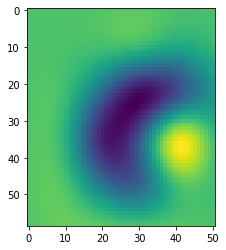

In [103]:
plt.imshow(field[15, :, :, 2])

In [83]:
import glob

allnames = glob.glob('/data/Apedata/CorrectData/data/Pongo/meshes/*.ply')
allnames = [x.split('/')[-1].split('-')[0] for x in allnames]
print(allnames)

['USNM588109', 'USNM153830', 'USNM145302', 'USNM142189', 'USNM142188', 'USNM145308', 'USNM153805', 'USNM142194', 'USNM197664', 'USNM145303', 'USNM399047', 'USNM153822', 'USNM142185', 'USNM145309', 'USNM153824', 'USNM145307', 'USNM145300', 'USNM153806']


In [82]:
allnames

['USNM176228',
 'USNM174701',
 'USNM084655',
 'USNM174704',
 'USNM174707',
 'USNM174703',
 'USNM220062',
 'USNM174710',
 'USNM220065',
 'USNM176236']

In [81]:
allnames.remove('USNM220063')

In [110]:
# Write the registered mesh

movingMeshPath = 'movingMeshRigidRegistered.vtk'
movingMesh = itk.meshread(movingMeshPath)

for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMeshFinalRegistered.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

In [121]:
print('Calculating distance between landmarks')

MOVING_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM176211_LM1.fcsv'
moving_landmark = read_landmarks(MOVING_LANDMARK_FILE)

mesh_moving_landmark = itk.Mesh[itk.D, 3].New()
mesh_moving_landmark.SetPoints(itk.vector_container_from_array(moving_landmark.flatten().astype('float32')))

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=first_transform)

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=second_transform)

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=final_transform)

# moving_landmark = itk.array_from_vector_container(mesh_moving_landmark.GetPoints())


Calculating distance between landmarks


In [176]:
m1 = np.load('moving_landmark.npy')
f1 = np.load('fixed_landmark.npy')

In [190]:
diff = m1 - f1
print(diff[0])

diff = np.square(diff)
print(diff[0])

diff = np.sum(diff, 1)
print(diff[0])

diff = np.sqrt(diff)
print(diff[0])
#np.save('diff_landmark.npy', diff)

[ 0.4483719 -1.8825657 14.140598 ]
[  0.20103735   3.5440538  199.95653   ]
203.70161
14.272408


In [183]:
print(m1[0])
print(f1[0])
print(d1[0])

[ 30.944654  -4.54917  -33.18866 ]
[ 30.496283   -2.6666043 -47.329258 ]
14.272408


In [182]:
t1 = m1[0] - f1[0]
print(t1)
print(np.square(t1))
print(np.sum(t1, 0))

[ 0.4483719 -1.8825657 14.140598 ]
[  0.20103735   3.5440538  199.95653   ]
12.706405


In [175]:
d1 = np.load('diff_landmark.npy')
print('mean distance ', np.mean(d1))
print(d1)

mean distance  52.08045
[ 14.272408   14.889301    5.056721    6.3611655   4.494349    1.9340465
  14.155607   19.130554   17.783134   34.389854   33.564537   37.1145
  39.824654   52.30405    55.192547   79.7469     82.44674    10.079343
  15.504842   31.699604   12.659089   68.35028    66.24091   112.576004
 109.66682    29.8028     33.345787   62.146427   68.75282   158.61354
 155.37991   127.32826   127.8302     65.01265    64.65288    37.853184
  39.87145    40.615364   38.040062   73.58407    73.03103  ]


In [ ]:
# 52.801685 -> numberOfGridNodesInOneDimension = 10, numOfIterations = 2500, maxStep = 0.2, learningRate = 0.2

In [197]:
import glob

allfiles = glob.glob('/data/Apedata/CorrectData/data/Gorilla/meshes/*.ply')
allnames = []

for x in allfiles:
    if '-' in x:
        allnames.append(x.split('/')[-1].split('-')[0])
    else:
        allnames.append(x.split('/')[-1].split('_')[0])

print(len(allnames))
print(allnames.remove('USNM176211'))
print(len(allnames))
print(allnames)

allnames = ["USNM174715"]

22
None
21
['USNM582726', 'USNM590951', 'USNM599165', 'USNM590953', 'USNM252577', 'USNM590947', 'USNM599167', 'USNM176217', 'USNM297857', 'USNM252575', 'USNM174715', 'USNM220324', 'USNM176216', 'USNM590954', 'USNM252580', 'USNM220060', 'USNM252578', 'USNM176209', 'USNM599166', 'USNM590942', 'USNM174722']


In [95]:
basepath = '/data/Apedata/Outputs/'

movingMesh = readvtk(basepath + 'USNM582726-Cranium_movingMeshFinalRegistered.vtk')
#movingMeshPoints = np.load(basepath + 'USNM582726-Cranium_movingMeshPoints.npy')
#fixedMeshPoints = np.load(basepath + 'USNM582726-Cranium_fixedMeshPoints.npy')

movingLandmarks = np.load(basepath + 'USNM582726-Cranium_moving_landmark.npy')
fixedLandmarks = np.load(basepath + 'USNM582726-Cranium_fixed_landmark.npy')

print(movingMeshPoints.shape)
print(movingMeshPoints.shape, movingLandmarks.shape)
print(fixedMeshPoints.shape, fixedLandmarks.shape)

(3391548, 3)
(3391548, 3) (41, 3)
(4315, 3) (41, 3)


In [133]:
# For calculating the metric between landmarks

allnames = [
    "USNM582726",
    "USNM590951",
    "USNM599165",
    "USNM590953",
    "USNM252577",
    "USNM590947",
    "USNM599167",
    "USNM176217",
    "USNM297857",
    "USNM252575",
    "USNM174715",
    "USNM220324",
    "USNM176216",
    "USNM590954",
    "USNM252580",
    "USNM220060",
    "USNM252578",
    "USNM176209",
    "USNM599166",
    "USNM590942",
    "USNM174722",
]

basepath = '/data/Apedata/Outputs/'

for name in allnames:
    print(name)
    #fixedMesh = readvtk(glob.glob(basepath + name + '*fixedMesh.vtk')[0])
    try:
        fixedMesh = readvtk(glob.glob(basepath + name + '*fixedMesh.vtk')[0])
        movingPath = glob.glob(basepath + name + '*moving_landmark.npy')[0]
        fixedPath = glob.glob(basepath + name + '*fixed_landmark.npy')[0]

        movingLandmarks = np.load(movingPath)
        fixedLandmarks = np.load(fixedPath)

        kDTree = vtk.vtkKdTreePointLocator()
        kDTree.SetDataSet(fixedMesh)

        transferred_landmarks = []
        for i in range(movingLandmarks.shape[0]):
            closest_point_id = kDTree.FindClosestPoint(movingLandmarks[i])
            closest_point = fixedMesh.GetPoint(closest_point_id)
            transferred_landmarks.append(list(closest_point))

        transferred_landmarks = np.array(transferred_landmarks)
        print(movingLandmarks.shape, fixedLandmarks.shape, transferred_landmarks.shape)

        np.save(basepath + name + '_transferred_landmark.npy', transferred_landmarks)

        diff = np.square(transferred_landmarks - fixedLandmarks)
        diff = np.sqrt(np.sum(diff, 1))
        np.save(basepath + name + '_diff_with_transferred_landmark.npy', diff)
    except:
        continue

USNM582726
(41, 3) (41, 3) (41, 3)
USNM590951
(41, 3) (41, 3) (41, 3)
USNM599165
(41, 3) (41, 3) (41, 3)
USNM590953
(41, 3) (41, 3) (41, 3)
USNM252577
(41, 3) (41, 3) (41, 3)
USNM590947
(41, 3) (41, 3) (41, 3)
USNM599167
(41, 3) (41, 3) (41, 3)
USNM176217
(41, 3) (41, 3) (41, 3)
USNM297857
(41, 3) (41, 3) (41, 3)
USNM252575
(41, 3) (41, 3) (41, 3)
USNM174715
(41, 3) (41, 3) (41, 3)
USNM220324
USNM176216
(41, 3) (41, 3) (41, 3)
USNM590954
(41, 3) (41, 3) (41, 3)
USNM252580
(41, 3) (41, 3) (41, 3)
USNM220060
(41, 3) (41, 3) (41, 3)
USNM252578
(41, 3) (41, 3) (41, 3)
USNM176209
USNM599166
(41, 3) (41, 3) (41, 3)
USNM590942
(41, 3) (41, 3) (41, 3)
USNM174722
(41, 3) (41, 3) (41, 3)


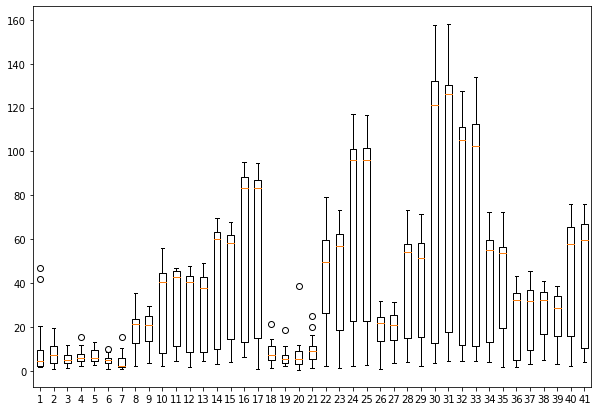

In [134]:
# Creating dataset
np.random.seed(10)
all_data = []
for i in range(41):
    all_data.append([])

for name in allnames:
    try:
        data = np.load(glob.glob(basepath + name + '*_diff_with_transferred_landmark.npy')[0])
        for i in range(41):
            all_data[i].append(data[i])
    except:
        continue
    
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(all_data)
 
# show plot
plt.show()

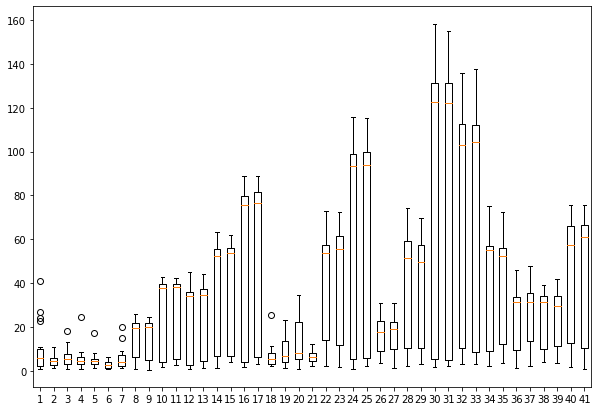

In [128]:
# Creating dataset
np.random.seed(10)
all_data = []
for i in range(41):
    all_data.append([])

for name in allnames:
    try:
        data = np.load(glob.glob(basepath + name + '*_diff_with_transferred_landmark.npy')[0])
        for i in range(41):
            all_data[i].append(data[i])
    except:
        continue
    
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(all_data)
 
# show plot
plt.show()

In [132]:
name

'USNM174722'

In [130]:
fixedMesh = readvtk(glob.glob(basepath + name + '*fixedMesh.vtk')[0])

In [131]:
itkwidgets.view(geometries=[fixedMesh], point_sets=[fixedLandmarks, transferred_landmarks])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [70]:
#filename = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174722-Cranium.vtk'
filename = '/data/Apedata/CorrectData/data/Pan/meshes/USNM176228-Cranium_merged_1.vtk'

reader = vtk.vtkPolyDataReader()
reader.SetFileName(filename)
reader.Update()

pointset = reader.GetOutput()

writer = vtk.vtkPLYWriter()
writer.SetFileName('test2.ply')
writer.SetInputData(pointset)
writer.Update()

In [134]:
# To get points and normals from vtk mesh

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

# Extracts the normal data from the sampled points
def extract_normal_from_tuple(input_mesh):
    t1 = input_mesh.GetPointData().GetArray("Normals")
    n1_array = []
    for i in range(t1.GetNumberOfTuples()):
        n1_array.append(t1.GetTuple(i))
    n1_array = np.array(n1_array)
    
    points = input_mesh.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    return as_numpy, n1_array

# Returns vtk points so that it has normal data also in it
def subsample_points_poisson_polydata(inputMesh):
    import vtk
    from vtk.util import numpy_support
    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    sampled_points = f.GetOutput()
    return sampled_points

def getnormals(inputmesh):
    normals = vtk.vtkTriangleMeshPointNormals()
    normals.SetInputData(inputmesh)
    normals.Update()
    return normals.GetOutput()

fixedMeshPath = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174722-Cranium.vtk'
movingMeshPath = '/data/Apedata/CorrectData/data/Pan/meshes/USNM176228-Cranium_merged_1.vtk'

fixedMesh  = readvtk(fixedMeshPath)
movingMesh  = readvtk(movingMeshPath)

movingMeshNormals = getnormals(movingMesh)
fixedMeshNormals = getnormals(fixedMesh)

movingMeshPoints = subsample_points_poisson_polydata(movingMeshNormals)
fixedMeshPoints  = subsample_points_poisson_polydata(fixedMeshNormals)

# Obtain normals from the sub-sampled points
movingMeshPoints, movingMeshPointNormals = extract_normal_from_tuple(movingMeshPoints)
fixedMeshPoints, fixedMeshPointNormals = extract_normal_from_tuple(fixedMeshPoints)

print(fixedMeshPoints.shape, fixedMeshPointNormals.shape)
print(movingMeshPoints.shape, movingMeshPointNormals.shape)

(7417, 3) (7417, 3)
(3663, 3) (3663, 3)


In [135]:
A_xyz = fixedMeshPoints.T
B_xyz = movingMeshPoints.T

In [132]:
# Load and visualize two point clouds from 3DMatch dataset
import open3d as o3d

#A_pcd_raw = o3d.io.read_point_cloud('/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174722-Cranium.ply')
#B_pcd_raw = o3d.io.read_point_cloud('/data/Apedata/CorrectData/data/Pan/meshes/USNM176228-Cranium_merged_1.ply')

#A_pcd_raw = o3d.io.read_point_cloud('test1.ply')
#B_pcd_raw = o3d.io.read_point_cloud('test2.ply')

A_pcd_raw = o3d.geometry.PointCloud()
A_pcd_raw.points = o3d.utility.Vector3dVector(fixedMeshPoints)

B_pcd_raw = o3d.geometry.PointCloud()
B_pcd_raw.points = o3d.utility.Vector3dVector(movingMeshPoints)

A_pcd_raw.paint_uniform_color([0.0, 0.0, 1.0]) # show A_pcd in blue
B_pcd_raw.paint_uniform_color([1.0, 0.0, 0.0]) # show B_pcd in red

o3d.visualization.draw_geometries([A_pcd_raw, B_pcd_raw]) # plot A and B

In [133]:
def pcd2xyz(pcd):
    return np.asarray(pcd.points).T

VOXEL_SIZE = 7

# voxel downsample both clouds
A_pcd = A_pcd_raw#A_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)
B_pcd = B_pcd_raw#B_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)

o3d.visualization.draw_geometries([A_pcd,B_pcd]) # plot downsampled A and B 

# extract the coordinates of both clouds as numpy array
A_xyz = pcd2xyz(A_pcd) # np array of size 3 by N
B_xyz = pcd2xyz(B_pcd) # np array of size 3 by M

print(A_xyz.shape, B_xyz.shape)

(3, 7417) (3, 3663)


In [261]:
# Extract FPFH features original library

def extract_fpfh(pcd, voxel_size):
    radius_normal = voxel_size * 2
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature,
                                             max_nn=100))
    return np.array(fpfh.data).T


#normS, indS = fpfh.calc_normals(pcS)


et = 0.1
div = 3
nneighbors = 14
rad = 35

if False:
    A_feats = extract_fpfh(A_pcd, VOXEL_SIZE)
    B_feats = extract_fpfh(B_pcd, VOXEL_SIZE)
else:
    fpfh = FPFH(et, div, nneighbors, rad)
    pcS = np.expand_dims(A_xyz.T, -1)
    normS, indS = fpfh.calc_normals(pcS)
    normS = fixedMeshPointNormals
    A_feats = fpfh.calcHistArray(A_xyz.T, normS, indS)
    
    fpfh = FPFH(et, div, nneighbors, rad)
    pcS = np.expand_dims(B_xyz.T, -1)
    normS, indS = fpfh.calc_normals(pcS)
    normS = movingMeshPointNormals
    B_feats = fpfh.calcHistArray(B_xyz.T, normS, indS)
    
    
print(A_feats.shape, B_feats.shape)
print(normS.shape, len(indS))

	Calculating surface normals. 

	Calculating histograms fast method 



invalid value encountered in arccos


	Calculating surface normals. 

	Calculating histograms fast method 



invalid value encountered in arccos


(7417, 27) (3663, 27)
(3663, 3) 3663


In [262]:
# establish correspondences by nearest neighbour search in feature space
from scipy.spatial import cKDTree


def find_knn_cpu(feat0, feat1, knn=1, return_distance=False):
    feat1tree = cKDTree(feat1)
    dists, nn_inds = feat1tree.query(feat0, k=knn, n_jobs=-1)
    if return_distance:
        return nn_inds, dists
    else:
        return nn_inds


def find_correspondences(feats0, feats1, mutual_filter=True):
    nns01 = find_knn_cpu(feats0, feats1, knn=1, return_distance=False)
    corres01_idx0 = np.arange(len(nns01))
    corres01_idx1 = nns01

    if not mutual_filter:
        return corres01_idx0, corres01_idx1

    nns10 = find_knn_cpu(feats1, feats0, knn=1, return_distance=False)
    corres10_idx1 = np.arange(len(nns10))
    corres10_idx0 = nns10

    mutual_filter = (corres10_idx0[corres01_idx1] == corres01_idx0)
    corres_idx0 = corres01_idx0[mutual_filter]
    corres_idx1 = corres01_idx1[mutual_filter]

    return corres_idx0, corres_idx1


corrs_A, corrs_B = find_correspondences(A_feats, B_feats, mutual_filter=True)

A_corr = A_xyz[:, corrs_A]  # np array of size 3 by num_corrs
B_corr = B_xyz[:, corrs_B]  # np array of size 3 by num_corrs

num_corrs = A_corr.shape[1]
print(f'FPFH generates {num_corrs} putative correspondences.')

# visualize the point clouds together with feature correspondences
points = np.concatenate((A_corr.T, B_corr.T), axis=0)
lines = []
for i in range(num_corrs):
    if i% 5 == 0:
        lines.append([i, i + num_corrs])

colors = [[0, 1*i%5, 0] for i in range(len(lines))]  # lines are shown in green
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)


line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([A_pcd, B_pcd, line_set])

The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.


FPFH generates 1637 putative correspondences.


In [263]:
# VTK Landmark transform

from vtk.util import numpy_support

source_points = vtk.vtkPoints()
source_points.SetData(numpy_support.numpy_to_vtk(A_corr.T, deep=True))

target_points = vtk.vtkPoints()
target_points.SetData(numpy_support.numpy_to_vtk(B_corr.T, deep=True))

landmarkTransform = vtk.vtkLandmarkTransform()

print(landmarkTransform.GetMatrix())

landmarkTransform.SetModeToSimilarity()
#landmarkTransform.SetModeToRigidBody()
landmarkTransform.SetSourceLandmarks(source_points)
landmarkTransform.SetTargetLandmarks(target_points)
landmarkTransform.Update()

vtkMatrix4x4 (0x5653eff96ec0)
  Debug: Off
  Modified Time: 3544576
  Reference Count: 2
  Registered Events: (none)
  Elements:
    1 0 0 0 
    0 1 0 0 
    0 0 1 0 
    0 0 0 1 


vtkMatrix4x4 (0x5653eff96ec0)
  Debug: Off
  Modified Time: 3544580
  Reference Count: 2
  Registered Events: (none)
  Elements:
    0.764923 0.00500435 -0.0100095 8.01194 
    -0.00617688 0.759382 -0.0923748 106.474 
    0.00933162 0.0924457 0.759341 181.672 
    0 0 0 1 




In [264]:
def itk_transform_from_vtk(vtk_transform):
    def vtkmatrix_to_numpy(matrix):
        """
        Copies the elements of a vtkMatrix4x4 into a numpy array.

        :param matrix: The matrix to be copied into an array.
        :type matrix: vtk.vtkMatrix4x4
        :rtype: numpy.ndarray
        """
        import numpy as np

        m = np.ones((4, 4))
        for i in range(4):
            for j in range(4):
                m[i, j] = matrix.GetElement(i, j)
        return np.array(m)


    m = landmarkTransform.GetMatrix()
    tp = vtkmatrix_to_numpy(m)
    
    itks = itk.Similarity3DTransform.New()
    itks.Translate(list(tp[:3, 3]))
    itks.SetMatrix(itk.matrix_from_array(tp[:3, :3]))
    
    return itks

temp_pointset = itk.Mesh[itk.D, 3].New()
temp_pointset.SetPoints(itk.vector_container_from_array(A_corr.T.flatten()))

itks = itk_transform_from_vtk(landmarkTransform)

new_pointset = itk.transform_mesh_filter(temp_pointset, transform=itks)
new_pointset = itk.array_from_vector_container(new_pointset.GetPoints())
print(new_pointset.shape)

(1637, 3)


In [265]:
itkwidgets.view(point_sets=[B_corr.T, new_pointset])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [124]:
# ITK Landmark transform

Dimension = 3

LandmarkPointType = itk.Point[itk.D, Dimension]
LandmarkContainerType = itk.vector[LandmarkPointType]

fixed_landmarks = LandmarkContainerType()
moving_landmarks = LandmarkContainerType()

fixed_point = LandmarkPointType()
moving_point = LandmarkPointType()

for i in range(A_corr.shape[0]):
    fixed_point[0] = A_corr[i][0]
    fixed_point[1] = A_corr[i][1]
    fixed_point[2] = A_corr[i][2]

    moving_point[0] = B_corr[i][0]
    moving_point[1] = B_corr[i][1]
    moving_point[2] = B_corr[i][2]

    fixed_landmarks.push_back(fixed_point)
    moving_landmarks.push_back(moving_point)

TransformInitializerType = itk.LandmarkBasedTransformInitializer[itk.Transform[itk.D, Dimension, Dimension]]
transform_initializer = TransformInitializerType.New()

transform_initializer.SetFixedLandmarks(fixed_landmarks)
transform_initializer.SetMovingLandmarks(moving_landmarks)

transform = itk.VersorRigid3DTransform[itk.D].New()
print(np.array(transform.GetParameters()))
transform_initializer.SetTransform(transform)
transform_initializer.InitializeTransform()
print(np.array(transform.GetParameters()))

[0. 0. 0. 0. 0. 0.]
[-3.70242012e-02 -4.36558866e-02 -3.82750704e-02  1.50683489e+02
  1.51055703e+02  1.53328724e+02]


In [57]:
o3d.visualization.draw_geometries([A_pcd, B_pcd])# line_set])

In [255]:
# For getting the FPFH feature using Point Feature Histogram github repo


class FPFH(object):
    """Parent class for PFH"""

    def __init__(self, e, div, nneighbors, radius):
        """Pass in parameters """
        self._e = e
        self._div = div
        self._nneighbors = nneighbors
        self._radius = radius

        self._error_list = []
        self._Rlist = []
        self._tlist = []

    def step(self, si, fi):
        """Helper function for calc_pfh_hist. Depends on selection of div
        :si: TODO
        :fi: TODO
        :returns: TODO
        """
        if self._div == 2:
            if fi < si[0]:
                result = 0
            else:
                result = 1
        elif self._div == 3:
            if fi < si[0]:
                result = 0
            elif fi >= si[0] and fi < si[1]:
                result = 1
            else:
                result = 2
        elif self._div == 4:
            if fi < si[0]:
                result = 0
            elif fi >= si[0] and fi < si[1]:
                result = 1
            elif fi >= si[1] and fi < si[2]:
                result = 2
            else:
                result = 3
        elif self._div == 5:
            if fi < si[0]:
                result = 0
            elif fi >= si[0] and fi < si[1]:
                result = 1
            elif fi >= si[1] and fi < si[2]:
                result = 2
            elif fi >= si[2] and fi < si[3]:
                result = 3
            else:
                result = 4
        return result

    def calc_thresholds(self):
        """
        :returns: 3x(div-1) array where each row is a feature's thresholds
        """
        delta = 2. / self._div
        s1 = np.array([-1 + i * delta for i in range(1, self._div)])

        delta = 2. / self._div
        s3 = np.array([-1 + i * delta for i in range(1, self._div)])

        delta = (np.pi) / self._div
        s4 = np.array([-np.pi / 2 + i * delta for i in range(1, self._div)])

        s = np.array([s1, s3, s4])
        return s

    def calc_pfh_hist(self, f):
        """Calculate histogram and bin edges.
        :f: feature vector of f1,f3,f4 (Nx3)
        :returns:
            pfh_hist - array of length div^3, represents number of samples per bin
            bin_edges - range(0, 1, 2, ..., (div^3+1)) 
        """
        # preallocate array sizes, create bin_edges
        pfh_hist, bin_edges = np.zeros(self._div**3), np.arange(
            0, self._div**3 + 1)

        # find the division thresholds for the histogram
        s = self.calc_thresholds()

        # Loop for every row in f from 0 to N
        for j in range(0, f.shape[0]):
            # calculate the bin index to increment
            index = 0
            for i in range(1, 4):
                index += self.step(s[i - 1, :], f[j, i - 1]) * (self._div
                                                                **(i - 1))

            # Increment histogram at that index
            pfh_hist[index] += 1

        return pfh_hist, bin_edges

    def convert_pc_to_matrix(self, pc):
        """Coverts a point cloud to a numpy matrix.
        Inputs:
            pc - a list of 3 by 1 numpy matrices.
        outputs:
            numpy_pc - a 3 by n numpy matrix where each column is a point.
        """
        numpy_pc = np.matrix(np.zeros((3, len(pc))))

        for index, pt in enumerate(pc):
            numpy_pc[0:3, index] = pt

        return numpy_pc

    def convert_matrix_to_pc(self, numpy_pc):
        """Coverts a numpy matrix to a point cloud (useful for plotting).
        Inputs:
            numpy_pc - a 3 by n numpy matrix where each column is a point.
        outputs:
            pc - a list of 3 by 1 numpy matrices.
        """
        pc = []

        for i in range(0, numpy_pc.shape[1]):
            pc.append((numpy_pc[0:3, i]))

        return pc

    def getNeighbors(self, pq, tree):
        """Get k nearest neighbors of the query point pq from pc, within the radius
            :pq: TODO
            :pc: TODO
            :returns: TODO
            """
        k = self._nneighbors
        neighbors = []
        
        dist, ind = tree.query(pq, k=k+1)
        dist_flag = dist < self._radius
        ind = ind[dist_flag]
        #print('neigbours are ', ind)
        #print(dist)
        #print(ind)
#         for i in range(len(pc)):
#             dist = np.linalg.norm(pq - pc[i])
#             if dist <= self._radius:  #0.005
#                 neighbors.append((dist, i))
#         #print("Found {} neighbors".format(len(neighbors)))
#         neighbors.sort(key=lambda x: x[0])
#         neighbors.pop(0)
        neighbors = ind[1:self._nneighbors+1]
        return neighbors

    def calc_normals(self, pc):
        """TODO: Docstring for calc_normals.
        :pc: TODO
        :returns: TODO
        """
        print("\tCalculating surface normals. \n")
        normals = []
        ind_of_neighbors = []
        N = len(pc)
        
        #print(pc.shape)
        from sklearn.neighbors import KDTree
        tree = KDTree(pc[:, :, 0], leaf_size=5)
        
        for i in range(N):
            # Get the indices of neighbors, it is a list of tuples (dist, indx)
            #print('check shape is ', pc[i].shape)
            indN = self.getNeighbors(pc[i].T, tree)  #<- old code
            #indN = list((neigh.kneighbors(pc[i].reshape(1, -1), return_distance=False)).flatten())
            #indN.pop(0)

            # Breakout just the indices
            #indN = [indN[i][1] for i in range(len(indN))]  #<- old code
            ind_of_neighbors.append(indN)

            '''
            # PCA
            X = pc[:, :, 0].T[:, indN]
            #print(X.shape)

            X = X - np.expand_dims(np.mean(X, axis=1), -1)
            if X.shape[1] == 0:
                print(X.shape)
            cov = np.matmul(X, X.T) / (len(indN))
            _, _, Vt = np.linalg.svd(cov)
            normal = Vt[2, :]

            # Re-orient normal vectors
            if np.matmul(normal, -1. * (pc[i])) < 0:
                normal = -1. * normal
            normals.append(normal)
            '''
        
        return normals, ind_of_neighbors

    def calcHistArray(self, pc, norm, indNeigh):
        """Overriding base PFH to FPFH"""

        print("\tCalculating histograms fast method \n")
        N = len(pc)
        histArray = np.zeros((N, self._div**3))
        distArray = np.zeros((self._nneighbors))
        distList = []
        for i in range(N):
            u = np.asarray(norm[i].T).squeeze()

            features = np.zeros((len(indNeigh[i]), 3))
            for j in range(len(indNeigh[i])):
                pi = pc[i]
                pj = pc[indNeigh[i][j]]
                if np.arccos(np.dot(norm[i], pj - pi)) <= np.arccos(
                        np.dot(norm[j], pi - pj)):
                    ps = pi
                    pt = pj
                    ns = np.asarray(norm[i]).squeeze()
                    nt = np.asarray(norm[indNeigh[i][j]]).squeeze()
                else:
                    ps = pj
                    pt = pi
                    ns = np.asarray(norm[indNeigh[i][j]]).squeeze()
                    nt = np.asarray(norm[i]).squeeze()

                u = ns
                difV = pt - ps
                dist = np.linalg.norm(difV)
                difV = difV / dist
                difV = np.asarray(difV).squeeze()
                v = np.cross(difV, u)
                w = np.cross(u, v)

                alpha = np.dot(v, nt)
                phi = np.dot(u, difV)
                theta = np.arctan(np.dot(w, nt) / np.dot(u, nt))

                features[j, 0] = alpha
                features[j, 1] = phi
                features[j, 2] = theta
                distArray[j] = dist

            distList.append(distArray)
            pfh_hist, bin_edges = self.calc_pfh_hist(features)
            histArray[i, :] = pfh_hist / (len(indNeigh[i]))

        fast_histArray = np.zeros_like(histArray)
        for i in range(N):
            k = len(indNeigh[i])
            for j in range(k):
                spfh_sum = histArray[indNeigh[i][j]] * (1 / distList[i][j])

            fast_histArray[i, :] = histArray[i, :] + (1 / k) * spfh_sum
        #print('checking feature ', len(fast_histArray), fast_histArray[0])
        return fast_histArray

    def findMatches(self, pcS, pcT):
        """Find matches from source to target points
        :pcS: Source point cloud
        :pcT: Target point cloud
        :returns: TODO
        """
        print("...Finding correspondences. \n")
        numS = len(pcS)
        numT = len(pcT)

        print("...Processing source point cloud...\n")
        normS, indS = self.calc_normals(pcS)
        ''' TODO: implement the different histograms '''
        #histS = calcHistArray_naive(pcT, normS, indS, div, nneighbors)
        #histS = calcHistArray_simple(pcT, normS, indS, div, nneighbors)
        histS = self.calcHistArray(pcS, normS, indS)

        print("...Processing target point cloud...\n")
        ''' TODO: implement the different histograms '''
        normT, indT = self.calc_normals(pcT)
        #histT = calcHistArray_naive(pcT, normT, indT, div, nneighbors)
        #histT = calcHistArray_simple(pcT, normT, indT, div, nneighbors)

        histT = self.calcHistArray(pcT, normT, indT)

        distance = []
        dist = []
        for i in range(numS):
            for j in range(numT):
                #appending the l2 norm and j
                dist.append((np.linalg.norm(histS[i] - histT[j]), j))
            dist.sort(
                key=lambda x: x[0])  #To sort by first element of the tuple
            distance.append(dist)
            dist = []
        return distance


et = 0.1
div = 2
nneighbors = 15
rad = 35

fpfh = FPFH(et, div, nneighbors, rad)

pcS = np.expand_dims(A_xyz, -1)

#normS, indS = fpfh.calc_normals(pcS)
#normS = 
#histS = fpfh.calcHistArray(A_xyz, normS, indS)

#
print(histS[0])

[0.33659264 0.00325931 0.16992597 0.50651862 0.00325931 0.
 0.         0.        ]
